# Purpose
This notebook demonstrates how Principal Components Analysis represents a linear rotation of axes. This is a simple case and uses only two variables.

## Pre-requisites
A CSV file "Two-asset PCA_CHANGES=4w.csv" in the current working directory. The file contains time series of changes of two financial variables on which this PCA demonstration is performed.

## Sequence of steps
1. Import necessary packages.
2. Define functions for plotting, formatting, etc.
3. Read data.
4. Normalise the data. De-mean and scale so that all time series have zero mean, and standard deviation 1.
5. Perform PCA.
6. Graphically show that the PCA is simply a rotation to new axes.

In [ ]:
# IMPORTS
import pandas as pd
import numpy as np

# For PCA
from statsmodels.multivariate import pca

# For plotting and formatting the plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtkr
import matplotlib.dates as mdts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive/vinci/PCA")

In [ ]:
# FUNCTION TO MAKE A SCATTER PLOT WITH EQUAL AXIS LENGTHS

def plot_equal_lengths_scatters(data, x_name, y_name):
    """
    This function makes a scatter plot. It also draws dotted lines to make the x-axis and y-axis more easy to see.

    data: pandas DataFrame with dates on the index, and x- and y-axes names as columns.
    This is the data for the scatter plot.
    x_name: String; the column name of the x-axis.
    y_name: String; the column name of the y-axis.

    Return: The matplotlib.Figure and matplotlib.axes.Axes for the plot.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    ax.axhline(y=0, color='black', linestyle=(0, (10, 6)), lw=0.5)
    ax.axvline(x=0, color='black', linestyle=(0, (10, 6)), lw=0.5)
    ax.scatter(x=data[x_name], y=data[y_name], s=15, marker='o', c='gainsboro', edgecolors='darkgrey')
    ax.set_xlabel(xlabel=x_name)
    ax.set_ylabel(ylabel=y_name)

    xlim_left, xlim_right = ax.get_xlim()
    ylim_bottom, ylim_top = ax.get_ylim()

    lim = np.max(np.abs(np.array([xlim_left, xlim_right, ylim_bottom, ylim_top])))

    ax.set_xlim(left=-lim, right=lim)
    ax.set_ylim(bottom=-lim, top=lim)

    return fig, ax

In [ ]:
# FUNCTION TO MAKE A TIME SERIES PLOT ON ONE AXIS

def plot_timeseries_one_axis(data, y_label=None):
    """
    This function plots a time series on a single axis.

    data: pandas DataFrame with dates on the index.
    y_label: A string providing the label to use for the y-axis. Optional. Defaults to None.

    Return: The matplotlib.Figure and matplotlib.axes.Axes for the plot.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    data.plot(ax=ax, lw=1.)
    if y_label is not None:
        ax.set_ylabel(ylabel=y_label)
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%b-%y'))
    ax.legend(loc='best', framealpha=0)
    return fig, ax

In [ ]:
# FUNCTION TO MAKE A TIME SERIES PLOT ON A PRIMARY AND A SECONDARY AXIS

def plot_timeseries_two_axes(data, cols_primary, cols_secondary, y_label_primary=None, y_label_secondary=None):
    """
    This function plots time series on a primary and secondary axis. (The maximum number of series that can be plotted
    on primary and secondary axes together is 10.)

    data: pandas DataFrame with dates on the index.
    cols_primary: A list of columns to plot on the primary y-axis.
    cols_secondary: A list of columns to plot on the secondary y-axis.
    y_label_primary: A string providing the label to use for the primary y-axis. Optional. Defaults to None.
    y_label_secondary: A string providing the label to use for the secondary y-axis. Optional. Defaults to None.

    Return: The matplotlib.Figure, and the two matplotlib.axes.Axes objects corresponding to the primary and
    secondary axes.
    """
    colours = ['black', 'silver', 'lightcoral', 'red', 'peru', 'olivedrab', 'limegreen', 'deepskyblue', 'royalblue',
               'darkorchid']

    if not isinstance(cols_primary, list):
        cols_primary = [cols_primary]
    if not isinstance(cols_secondary, list):
        cols_secondary = [cols_secondary]

    data_primary = data[cols_primary].rename(
        mapper={c: ' '.join([c, '(left)']) for c in cols_primary},
        axis=1)
    data_secondary = data[cols_secondary].rename(
        mapper={c: ' '.join([c, '(right)']) for c in cols_secondary},
        axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    data_primary.plot(ax=ax, lw=1., color=colours[:data_primary.shape[1]])
    if y_label_primary is not None:
        ax.set_ylabel(ylabel=y_label_primary)
    ax.legend().set_visible(False)

    ax2 = ax.twinx()
    ax2.grid(visible=False)
    data_secondary.plot(ax=ax2, lw=1.,
                        color=colours[data_primary.shape[1]:(data_primary.shape[1] + data_secondary.shape[1])])
    if y_label_secondary is not None:
        ax2.set_ylabel(ylabel=y_label_secondary)
    ax2.legend().set_visible(False)

    ax.xaxis.set_major_formatter(mdts.DateFormatter('%b-%y'))
    lns = ax.lines + ax2.lines
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best', framealpha=0)

    return fig, ax, ax2

In [ ]:
# FUNCTIONS FOR FORMATTING AND DISPLAY

def format_beta(beta, change_type, change_unit):
    if change_unit == '%':
        if change_type == 'LOGRETURN':
            formatted = np.exp(beta) - 1.
        formatted = '{:.2%}'.format(beta)
    else:
        formatted = '{:.1f}'.format(beta)
    return formatted

format_colour = lambda x: 'color:red' if x < 0. else 'color:blue'

In [ ]:
# READ DATA; SHOW THE DATAFRAME

change_freq = '4w'
changes = pd.read_csv(filepath_or_buffer='_'.join(['Two-asset PCA', 'CHANGES=' + change_freq]) + '.csv',
                      index_col=0, header=0,
                      parse_dates=True).astype(np.float64)
x_name, y_name = changes.columns[0], changes.columns[1]

n_assets = changes.shape[1]
changes

,S&P 500,US High Yield Total Return
1999-02-03,-0.000212,0.010878
1999-03-03,-0.035503,-0.007980
1999-03-31,0.046682,0.013265
1999-04-28,0.048954,0.018370
1999-05-26,-0.034759,-0.008517
...,...,...
2022-12-07,0.048262,0.037365
2023-01-04,-0.020792,0.000751
2023-02-01,0.066817,0.030657
2023-03-01,-0.041594,-0.019010


In [ ]:
# NORMALISE THE CHANGES TO HAVE ZERO MEAN, STANDARD DEVIATION 1; SHOW THE NORMALISED CHANGES

changes_normalised = (changes - changes.mean()) / changes.std()
changes_normalised

,S&P 500,US High Yield Total Return
1999-02-03,-0.084472,0.244860
1999-03-03,-0.856978,-0.480306
1999-03-31,0.942028,0.336670
1999-04-28,0.991769,0.532986
1999-05-26,-0.840700,-0.500970
...,...,...
2022-12-07,0.976617,1.263421
2023-01-04,-0.534960,-0.144537
2023-02-01,1.382785,1.005478
2023-03-01,-0.990309,-0.904458


In [ ]:
# SHOW THE CORRELATION MATRIX OF THE DATA

changes_normalised.corr().style.format(formatter='{:.0%}')

,S&P 500,US High Yield Total Return
S&P 500,100%,64%
US High Yield Total Return,64%,100%


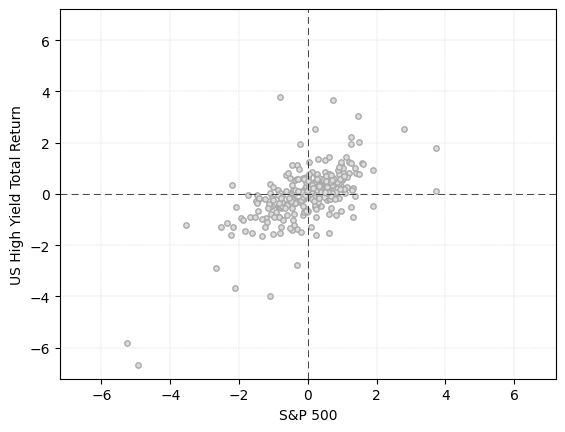

In [ ]:
# CREATE A SCATTER PLOT OF NORMALISED DATA

fig_0, ax_0 = plot_equal_lengths_scatters(data=changes_normalised, x_name=x_name, y_name=y_name)
min_x, max_x = ax_0.get_xlim()
min_y, max_y = ax_0.get_ylim()

In [ ]:
# PERFORM PCA; OBTAIN THE LOADING MATRIX & SCORES

pca_model = pca.PCA(data=changes_normalised.values, standardize=True, normalize=False)
loadings = pca_model.loadings
scores = pca_model.scores

In [ ]:
# LOADINGS: THE FACTOR LOADING MATRIX OF THE PCA
# loadings is a numpy array

loadings

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [ ]:
# Convert the numpy array loadings to a pandas DataFrame for ease of viewing

loadings_df = pd.DataFrame(
    index=changes_normalised.columns,
    columns=[' '.join(['PC', str(j + 1)]) for j in range(n_assets)],
    data=loadings)


loadings_df.style.format(formatter='{:+.2f}').applymap(func=format_colour)

,PC 1,PC 2
S&P 500,+0.71,+0.71
US High Yield Total Return,+0.71,-0.71


**The loadings above tell us the following:**

**1. When PC 1 > 0, both S&P 500 and US High Yield bonds have positive returns This is most likely the "risk appetite" factor.**

**2. When PC 2 > 0, S&P 500 rises and US High Yield bonds have negative returns. When positive, this factor equates to "preference for equities over credit". When negative, the factor means "preference for credit over equity".**

In [ ]:
# SCORES: THE TIME SERIES OF PRINCIPAL COMPONENTS CORRESPONDING TO THE CHANGES SUPPLIED
# scores is a numpy array

scores

array([[ 1.13591548e-01, -2.33241950e-01],
       [-9.47102843e-01, -2.66769774e-01],
       [ 9.05610036e-01,  4.28731498e-01],
       [ 1.07987474e+00,  3.24922856e-01],
       [-9.50208504e-01, -2.40605917e-01],
       [-5.37986059e-02,  6.06051372e-01],
       [ 7.29926243e-01,  2.14051664e-01],
       [-1.23232494e+00,  5.70895466e-02],
       [-4.26884689e-01, -3.40508450e-02],
       [-7.27874578e-01, -1.57429577e-01],
       [ 9.07551143e-01,  1.03030995e+00],
       [ 4.15647652e-01,  1.50520342e-01],
       [-1.77997505e-01,  2.58108353e-02],
       [-7.51683245e-02,  1.16729458e-01],
       [-4.94292409e-01, -2.84444255e-01],
       [ 1.00607549e+00,  1.65999676e+00],
       [-9.32389839e-01, -1.73326573e-01],
       [-1.06827742e+00, -3.87995001e-01],
       [ 1.00230968e+00,  6.10429075e-01],
       [ 1.96211590e-01, -2.50015091e-01],
       [-2.15386836e-01,  5.81394539e-02],
       [ 2.88469792e-01, -2.95703218e-01],
       [-2.03900378e+00, -6.94070053e-01],
       [-6.

In [ ]:
# OBTAIN THE DATAFRAME OF PRINCIPAL COMPONENT SCORES
# Convert the numpy array scores to a pandas DataFrame

scores_df = pd.DataFrame(
    index=changes_normalised.index,
    columns=loadings_df.columns,
    data=scores)
scores_df

,PC 1,PC 2
1999-02-03,0.113592,-0.233242
1999-03-03,-0.947103,-0.266770
1999-03-31,0.905610,0.428731
1999-04-28,1.079875,0.324923
1999-05-26,-0.950209,-0.240606
...,...,...
2022-12-07,1.586458,-0.203123
2023-01-04,-0.481239,-0.276509
2023-02-01,1.691435,0.267220
2023-03-01,-1.341928,-0.060802


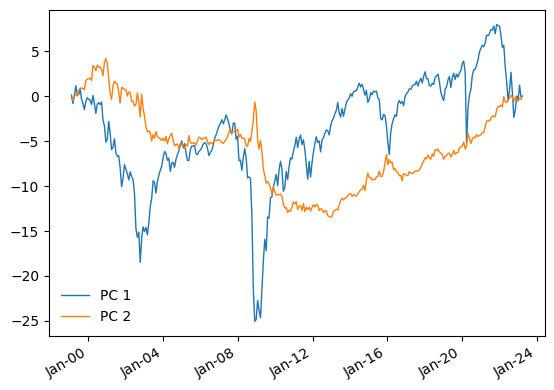

In [ ]:
# PLOT A TIME SERIES OF CUMULATED PRINCIPAL COMPONENT SCORES

scores_cum_df = scores_df.cumsum()
fig_1, ax_1 = plot_timeseries_one_axis(data=scores_cum_df)

**The chart above helps us understand the factors better.**

**1. PC1 had big falls in the early 2000s, late 2008, 2H 2015, 1Q 2020, and in 2022. These falls coincide with significant market selloffs in equities and/or credit.**

**2. PC 2 fell steadily from mid-2003 until 2008. This coincided with the pre-GFC credit boom. PC2 fell again from about 2009 as the US Federal Reserve undertook unconventional monetary policy. PC 2 started to rise from mid-2016 as there was a strong demand for equities.**

### PCA as a rotation of axes
We now graphically rotate the x- and y-axes using the loading matrix. We add these rotated axes to the scatter plot above.

The rotated x-axis now falls along the line of maximum variance. The rotated y-axis is orthogonal to this rotated x-axis.

Rotation is a simple matrix multiplaction.

In [ ]:
# ROTATE THE X-AXIS; SHOW THE ROTATED X-AXIS
# We re-create the x-axis with a 2-D numpy array.
# The first column has values from min_x to max_x. The second column has all zeros.

col_0 = np.linspace(start=min_x, stop=max_x, num=50).reshape((50, 1))
col_1 = np.zeros((50, 1))
xaxis_0 = np.concatenate((col_0, col_1), axis=1)
xaxis_rotated_0 = np.matmul(xaxis_0, loadings)

pd.DataFrame(
    columns=pd.MultiIndex.from_tuples([('Initial', 'x'), ('Initial', 'y'), ('Rotated', 'x'), ('Rotated', 'y')]),
    data=np.concatenate((xaxis_0, xaxis_rotated_0), axis=1))

Initial        Rotated          
           x    y         x         y
0  -7.211452  0.0 -5.099267 -5.099267
1  -6.917107  0.0 -4.891133 -4.891133
2  -6.622762  0.0 -4.683000 -4.683000
3  -6.328417  0.0 -4.474867 -4.474867
4  -6.034072  0.0 -4.266733 -4.266733
5  -5.739727  0.0 -4.058600 -4.058600
6  -5.445382  0.0 -3.850467 -3.850467
7  -5.151037  0.0 -3.642333 -3.642333
8  -4.856692  0.0 -3.434200 -3.434200
9  -4.562347  0.0 -3.226067 -3.226067
10 -4.268002  0.0 -3.017933 -3.017933
11 -3.973657  0.0 -2.809800 -2.809800
12 -3.679312  0.0 -2.601667 -2.601667
13 -3.384967  0.0 -2.393533 -2.393533
14 -3.090622  0.0 -2.185400 -2.185400
15 -2.796277  0.0 -1.977267 -1.977267
16 -2.501932  0.0 -1.769133 -1.769133
17 -2.207587  0.0 -1.561000 -1.561000
18 -1.913242  0.0 -1.352867 -1.352867
19 -1.618897  0.0 -1.144733 -1.144733
20 -1.324552  0.0 -0.936600 -0.936600
21 -1.030207  0.0 -0.728467 -0.728467
22 -0.735862  0.0 -0.520333 -0.520333
23 -0.441517  0.0 -0.312200 -0.312200
24 -0.147172  0.0 -0.104067 -0.104067
25  0.147172  0.0  0.104067  0.104067
26  0.441517  0.0  0.312200  0.312200
27  0.735862  0.0  0.520333  0.520333
28  1.030207  0.0  0.728467  0.728467
29  1.324552  0.0  0.936600  0.936600
30  1.618897  0.0  1.144733  1.144733
31  1.913242  0.0  1.352867  1.352867
32  2.207587  0.0  1.561000  1.561000
33  2.501932  0.0  1.769133  1.769133
34  2.796277  0.0  1.977267  1.977267
35  3.090622  0.0  2.185400  2.185400
36  3.384967  0.0  2.393533  2.393533
37  3.679312  0.0  2.601667  2.601667
38  3.973657  0.0  2.809800  2.809800
39  4.268002  0.0  3.017933  3.017933
40  4.562347  0.0  3.226067  3.226067
41  4.856692  0.0  3.434200  3.434200
42  5.151037  0.0  3.642333  3.642333
43  5.445382  0.0  3.850467  3.850467
44  5.739727  0.0  4.058600  4.058600
45  6.034072  0.0  4.266733  4.266733
46  6.328417  0.0  4.474867  4.474867
47  6.622762  0.0  4.683000  4.683000
48  6.917107  0.0  4.891133  4.891133
49  7.211452  0.0  5.099267  5.099267

In [ ]:
# ROTATE THE Y-AXIS; SHOW THE ROTATED Y-AXIS
# We re-create the y-axis with a 2-D numpy array.
# The first column has all zeros. The second column has values from min_y to max_y.

col_0 = np.zeros((50, 1))
col_1 = np.linspace(start=min_y, stop=max_y, num=50).reshape((50, 1))
yaxis_0 = np.concatenate((col_0, col_1), axis=1)
yaxis_rotated_0 = np.matmul(yaxis_0, loadings)

pd.DataFrame(
    columns=pd.MultiIndex.from_tuples([('Initial', 'x'), ('Initial', 'y'), ('Rotated', 'x'), ('Rotated', 'y')]),
    data=np.concatenate((yaxis_0, yaxis_rotated_0), axis=1))

Initial             Rotated          
         x         y         x         y
0      0.0 -7.211452 -5.099267  5.099267
1      0.0 -6.917107 -4.891133  4.891133
2      0.0 -6.622762 -4.683000  4.683000
3      0.0 -6.328417 -4.474867  4.474867
4      0.0 -6.034072 -4.266733  4.266733
5      0.0 -5.739727 -4.058600  4.058600
6      0.0 -5.445382 -3.850467  3.850467
7      0.0 -5.151037 -3.642333  3.642333
8      0.0 -4.856692 -3.434200  3.434200
9      0.0 -4.562347 -3.226067  3.226067
10     0.0 -4.268002 -3.017933  3.017933
11     0.0 -3.973657 -2.809800  2.809800
12     0.0 -3.679312 -2.601667  2.601667
13     0.0 -3.384967 -2.393533  2.393533
14     0.0 -3.090622 -2.185400  2.185400
15     0.0 -2.796277 -1.977267  1.977267
16     0.0 -2.501932 -1.769133  1.769133
17     0.0 -2.207587 -1.561000  1.561000
18     0.0 -1.913242 -1.352867  1.352867
19     0.0 -1.618897 -1.144733  1.144733
20     0.0 -1.324552 -0.936600  0.936600
21     0.0 -1.030207 -0.728467  0.728467
22     0.0 -0.735862 -0.520333  0.520333
23     0.0 -0.441517 -0.312200  0.312200
24     0.0 -0.147172 -0.104067  0.104067
25     0.0  0.147172  0.104067 -0.104067
26     0.0  0.441517  0.312200 -0.312200
27     0.0  0.735862  0.520333 -0.520333
28     0.0  1.030207  0.728467 -0.728467
29     0.0  1.324552  0.936600 -0.936600
30     0.0  1.618897  1.144733 -1.144733
31     0.0  1.913242  1.352867 -1.352867
32     0.0  2.207587  1.561000 -1.561000
33     0.0  2.501932  1.769133 -1.769133
34     0.0  2.796277  1.977267 -1.977267
35     0.0  3.090622  2.185400 -2.185400
36     0.0  3.384967  2.393533 -2.393533
37     0.0  3.679312  2.601667 -2.601667
38     0.0  3.973657  2.809800 -2.809800
39     0.0  4.268002  3.017933 -3.017933
40     0.0  4.562347  3.226067 -3.226067
41     0.0  4.856692  3.434200 -3.434200
42     0.0  5.151037  3.642333 -3.642333
43     0.0  5.445382  3.850467 -3.850467
44     0.0  5.739727  4.058600 -4.058600
45     0.0  6.034072  4.266733 -4.266733
46     0.0  6.328417  4.474867 -4.474867
47     0.0  6.622762  4.683000 -4.683000
48     0.0  6.917107  4.891133 -4.891133
49     0.0  7.211452  5.099267 -5.099267

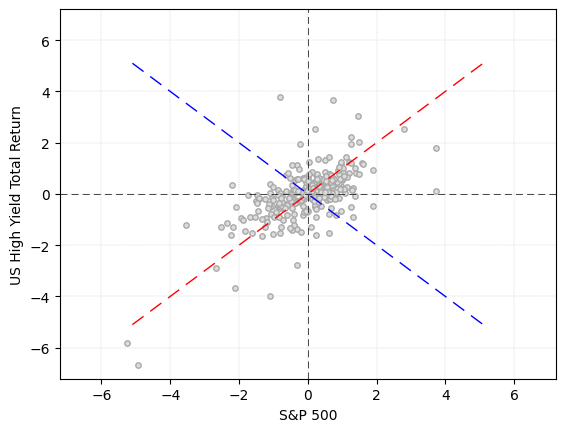

In [ ]:
# SCATTER PLOT OF DATA AND ROTATED AXES

fig_1, ax_1 = plot_equal_lengths_scatters(data=changes_normalised, x_name=x_name, y_name=y_name)

ax_1.plot(xaxis_rotated_0[:, 0], xaxis_rotated_0[:, 1], color='red', linestyle=(0, (10, 6)), lw=1)
ax_1.plot(yaxis_rotated_0[:, 0], yaxis_rotated_0[:, 1], color='blue', linestyle=(0, (10, 6)), lw=1)

**The rotated x-axis (in red) is along the axis is of highest variance.**

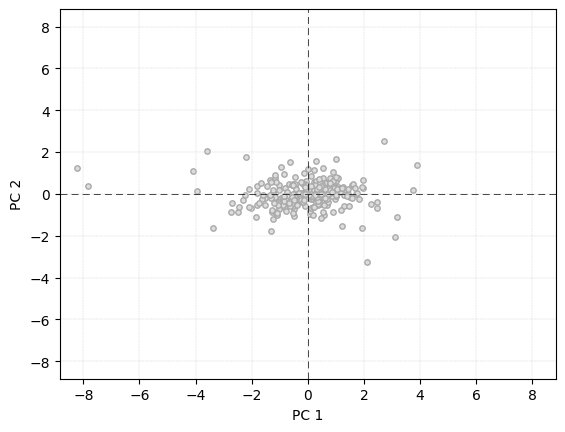

In [ ]:
# SCATTER PLOT OF PRINCIPAL COMPONENT SCORES

fig_2, ax_2 = plot_equal_lengths_scatters(data=scores_df, x_name=scores_df.columns[0], y_name=scores_df.columns[1])

**The scatter plot above shows highest variance along the x-axis, and then the remaining variance along the y-axis.**

In [ ]:
# CORRELATION MATRIX OF PRINCIPAL COMPONENT SCORES

scores_df.corr().style.format('{:.0%}')

,PC 1,PC 2
PC 1,100%,0%
PC 2,0%,100%


**The PCs are "orthogonal" and uncorrelated.**

### Additional: some linear algebra aspects of PCA

Notation:

$X$ is the $n$ x $p$ matrix of data on which we perform the PCA. Here $n$ is the number of observations (rows) and $p$ is the number of variables (columns).

$L$ is the $p$ x $p$ PCA loading matrix.

$F$ is the $n$ x $p$ matrix of PCA factors or scores.

Then, we have the following relationships:

$F = X L$

$X = (L F^{T})^{T}$

$L$ is the matrix of eigenvectors of the covariance matrix of the matrix $X$. The matrix of eigenvectors of a symmetric matrix - which the covariance matrix is - is always orthogonal. Thus, we get:

$L^{T} = L^{-1} => L L^{T} = I$, where $I$ is the identity matrix

In [ ]:
# OBTAIN PCA SCORES USING MATRIX MULTIPLICATION

np.matmul(changes_normalised.values, loadings)

array([[ 1.13411672e-01, -2.32872603e-01],
       [-9.45603075e-01, -2.66347335e-01],
       [ 9.04175973e-01,  4.28052588e-01],
       [ 1.07816472e+00,  3.24408331e-01],
       [-9.48703819e-01, -2.40224910e-01],
       [-5.37134141e-02,  6.05091670e-01],
       [ 7.28770381e-01,  2.13712706e-01],
       [-1.23037351e+00,  5.69991435e-02],
       [-4.26208704e-01, -3.39969244e-02],
       [-7.26721965e-01, -1.57180283e-01],
       [ 9.06114007e-01,  1.02867842e+00],
       [ 4.14989461e-01,  1.50281988e-01],
       [-1.77715640e-01,  2.57699630e-02],
       [-7.50492930e-02,  1.16544613e-01],
       [-4.93509681e-01, -2.83993828e-01],
       [ 1.00448234e+00,  1.65736810e+00],
       [-9.30913369e-01, -1.73052104e-01],
       [-1.06658577e+00, -3.87380599e-01],
       [ 1.00072249e+00,  6.09462441e-01],
       [ 1.95900883e-01, -2.49619184e-01],
       [-2.15045764e-01,  5.80473882e-02],
       [ 2.88012991e-01, -2.95234962e-01],
       [-2.03577496e+00, -6.92970971e-01],
       [-6.

In [ ]:
# OBTAIN THE INITIAL DATA USING MATRIX MULTIPLICATION OF LOADINGS AND PCA SCORES TRANSPOSED

np.matmul(loadings, scores.T).T

array([[-8.46056102e-02,  2.45248318e-01],
       [-8.58337559e-01, -4.81068127e-01],
       [ 9.43521947e-01,  3.37204048e-01],
       [ 9.93341906e-01,  5.33831595e-01],
       [-8.42032953e-01, -5.01764801e-01],
       [ 3.90501676e-01, -4.66584394e-01],
       [ 6.67493179e-01,  3.64778413e-01],
       [-8.31016915e-01, -9.11753726e-01],
       [-3.25930642e-01, -2.77775475e-01],
       [-6.26004572e-01, -4.03365528e-01],
       [ 1.37027472e+00, -8.68035835e-02],
       [ 4.00341228e-01,  1.87473319e-01],
       [-1.07612226e-01, -1.44114259e-01],
       [ 2.93881596e-02, -1.35692223e-01],
       [-5.50649976e-01, -1.48385052e-01],
       [ 1.88519777e+00, -4.62392165e-01],
       [-7.81859572e-01, -5.36738783e-01],
       [-1.02974011e+00, -4.81032314e-01],
       [ 1.14037851e+00,  2.77101431e-01],
       [-3.80448202e-02,  3.15529912e-01],
       [-1.11190690e-01, -1.93412294e-01],
       [-5.11480470e-03,  4.13072697e-01],
       [-1.93257504e+00, -9.51011761e-01],
       [ 6.

In [ ]:
# ORTHOGONALITY OF THE LOADING MATRIX

np.matmul(loadings, loadings.T)

array([[1.00000000e+00, 4.26642159e-17],
       [4.26642159e-17, 1.00000000e+00]])

## Disclaimer
ANALYST CERTIFICATION

Each author of this research report listed on the cover hereby certifies that the views expressed in the research report accurately reflect his or her personal views, including views about subject securities or issuers mentioned in the report, if any. No part of his or her compensation was, is or will be related, directly or indirectly to the specific recommendations or views expressed in this report.

The analyst(s) who author research are employed by SG and its affiliates in locations, including but not limited to, Paris, London, New York, Hong Kong, Tokyo, Bangalore, Frankfurt, Madrid, Milan, Geneva, Seoul, Warsaw, Moscow and Casablanca.

CONFLICTS OF INTEREST

This research contains the views, opinions and recommendations of Societe Generale (SG) credit research analysts and/or strategists. To the extent that this research contains trade ideas based on macro views of economic market conditions or relative value, it may differ from the fundamental credit opinions and recommendations contained in credit sector or company research reports and from the views and opinions of other departments of SG and its affiliates. Credit research analysts and/or strategists routinely consult with SG sales and trading desk personnel regarding market information including, but not limited to, pricing, spread levels and trading activity of a specific fixed income security or financial instrument, sector or other asset class. Trading desks may trade, or have traded, as principal on the basis of the research analyst(s) views and reports. As a general matter, SG and/or its affiliates normally make a market and trade as principal in fixed income securities discussed in research reports. SG has mandatory research policies and procedures that are reasonably designed to (i) ensure that purported facts in research reports are based on reliable information and (ii) to prevent improper selective or tiered dissemination of research reports. In addition, research analysts receive compensation based, in part, on the quality and accuracy of their analysis, client feedback, competitive factors and SGâ€™s total revenues including revenues from sales and trading and investment banking.

IMPORTANT NOTICE: Sections of this publication that are contributed by non-independent analysts should not be construed as investment research as such have not been prepared in accordance with legal requirements designed to promote the independence of investment research. Therefore, even if such sections contain a research recommendation, such sections should be treated as a marketing communication and not as investment research. SG is required to have policies in place to manage the conflicts which may arise in the production of its research, including preventing dealing ahead of investment research.

IMPORTANT DISCLAIMER: The information herein is not intended to be an offer to buy or sell, or a solicitation of an offer to buy or sell, any securities or security-based swaps and has been obtained from, or is based upon, sources believed to be reliable but is not guaranteed as to accuracy or completeness. Material contained in this report satisfies the regulatory provisions concerning independent investment research as defined in MiFID. Information concerning conflicts of interest and SGâ€™s management of such conflicts is contained in the SGâ€™s Policies for Managing Conflicts of Interests in Connection with Investment Research which is available at https://www.sgmarkets.com/#/compliance/equity or https://www.sgmarkets.com/#credit/compliance SG does, from time to time, deal, trade in, profit from, hold, act as market-makers or advisers, brokers or bankers in relation to the securities, or derivatives thereof, of persons, firms or entities mentioned in this document and may be represented on the board of such persons, firms or entities. SG does, from time to time, act as a principal trader in equities or debt securities that may be referred to in this report and may hold equity or debt securities positions or related derivatives. Employees of SG, or individuals connected to them, may from time to time have a position in or hold any of the investments or related investments mentioned in this document. SG is under no obligation to disclose or take account of this document when advising or dealing with or on behalf of customers. The views of SG reflected in this document may change without notice. In addition, SG may issue other reports that are inconsistent with, and reach different conclusions from, the information presented in this report and is under no obligation to ensure that such other reports are brought to the attention of any recipient of this report. To the maximum extent possible at law, SG does not accept any liability whatsoever arising from the use of the material or information contained herein. This research document is not intended for use by or targeted to retail customers. Should a retail customer obtain a copy of this report he/she should not base his/her investment decisions solely on the basis of this document and must seek independent financial advice.

The financial instruments discussed in this report may not be suitable for all investors and investors must make their own informed decisions and seek their own advice regarding the appropriateness of investing in financial instruments or implementing strategies discussed herein. The value of securities and financial instruments is subject to currency exchange rate fluctuation that may have a positive or negative effect on the price of such securities or financial instruments, and investors in securities such as ADRs effectively assume this risk. SG does not provide any tax advice. Past performance is not necessarily a guide to future performance. Estimates of future performance are based on assumptions that may not be realized. Investments in general, and derivatives in particular, involve numerous risks, including, among others, market, counterparty default and liquidity risk. Trading in options involves additional risks and is not suitable for all investors. An option may become worthless by its expiration date, as it is a depreciating asset. Option ownership could result in significant loss or gain, especially for options of unhedged positions. Prior to buying or selling an option, investors must review the "Characteristics and Risks of Standardized Options" at http://www.optionsclearing.com/about/publications/character-risks.jsp. or from your SG representative. Analysis of option trading strategies does not consider the cost of commissions. Supporting documentation for options trading strategies is available upon request.

Notice to French Investors: This publication is issued in France by or through SociÃ©tÃ© GÃ©nÃ©rale ("SG") which is authorised and supervised by the AutoritÃ© de ContrÃ´le Prudentiel et de RÃ©solution (ACPR) and regulated by the AutoritÃ© des MarchÃ©s Financiers (AMF). Notice to U.K. Investors: SociÃ©tÃ© GÃ©nÃ©rale is a French credit institution (bank) authorised by the AutoritÃ© de ContrÃ´le Prudentiel (the French Prudential Control Authority) and the Prudential Regulation Authority and subject to limited regulation by the Financial Conduct Authority and Prudential Regulation Authority. Details about the extent of our authorisation and regulation by the Prudential Regulation Authority, and regulation by the Financial Conduct Authority are available from us on request. Notice to Swiss Investors: This document is provided in Switzerland by or through SociÃ©tÃ© GÃ©nÃ©rale Paris, ZÃ¼rich Branch, and is provided only to qualified investors as defined in article 10 of the Swiss Collective Investment Scheme Act (â€œCISAâ€) and related provisions of the Collective Investment Scheme Ordinance and in strict compliance with applicable Swiss law and regulations. The products mentioned in this document may not be suitable for all types of investors. This document is based on the Directives on the Independence of Financial Research issued by the Swiss Bankers Association (SBA) in January 2008. Notice to Polish Investors: this document has been issued in Poland by Societe Generale S.A. Oddzial w Polsce (â€œthe Branchâ€) with its registered office in Warsaw (Poland) at 111 MarszaÅ‚kowska St. The Branch is supervised by the Polish Financial Supervision Authority and the French â€AutoritÃ© de ContrÃ´le Prudentielâ€. This report is addressed to financial institutions only, as defined in the Act on trading in financial instruments. The Branch certifies that this document has been elaborated with due diligence and care. Notice to U.S. Investors: For purposes of SEC Rule 15a-6, SG Americas Securities LLC (â€œSGASâ€) takes responsibility for this research report. This report is intended for institutional investors only. Any U.S. person wishing to discuss this report or effect transactions in any security discussed herein should do so with or through SGAS, a U.S. registered broker-dealer and futures commission merchant (FCM). SGAS is a member of FINRA, NYSE and NFA. Its registered address at 245 Park Avenue, New York, NY, 10167. (212)-278-6000. Notice to Canadian Investors: This document is for information purposes only and is intended for use by Permitted Clients, as defined under National Instrument 31-103, Accredited Investors, as defined under National Instrument 45-106, Accredited Counterparties as defined under the Derivatives Act (QuÃ©bec) and "Qualified Parties" as defined under the ASC, BCSC, SFSC and NBSC Orders Notice to Singapore Investors: This document is provided in Singapore by or through SociÃ©tÃ© GÃ©nÃ©rale ("SG"), Singapore Branch and is provided only to accredited investors, expert investors and institutional investors, as defined in Section 4A of the Securities and Futures Act, Cap. 289. Recipients of this document are to contact SociÃ©tÃ© GÃ©nÃ©rale, Singapore Branch in respect of any matters arising from, or in connection with, the document. If you are an accredited investor or expert investor, please be informed that in SG's dealings with you, SG is relying on the following exemptions to the Financial Advisers Act, Cap. 110 (â€œFAAâ€): (1) the exemption in Regulation 33 of the Financial Advisers Regulations (â€œFARâ€), which exempts SG from complying with Section 25 of the FAA on disclosure of product information to clients; (2) the exemption set out in Regulation 34 of the FAR, which exempts SG from complying with Section 27 of the FAA on recommendations; and (3) the exemption set out in Regulation 35 of the FAR, which exempts SG from complying with Section 36 of the FAA on disclosure of certain interests in securities. Notice to Hong Kong Investors: This report is distributed or circulated in Hong Kong only to â€œprofessional investorsâ€ as defined in the Securities and Futures Ordinance (Chapter 571 of the Laws of Hong Kong) (â€œSFOâ€). Any such professional investor wishing to discuss this report or take any action in connection with it should contact SG Securities (HK) Limited. This report does not constitute a solicitation or an offer of securities or an invitation to the public within the meaning of the SFO. Notice to Japanese Investors: This publication is distributed in Japan by Societe Generale Securities Japan Limited, which is regulated by the Financial Services Agency of Japan. This document is intended only for the Specified Investors, as defined by the Financial Instruments and Exchange Law in Japan and only for those people to whom it is sent directly by Societe Generale Securities Japan Limited, and under no circumstances should it be forwarded to any third party. The products mentioned in this report may not be eligible for sale in Japan and they may not be suitable for all types of investors. Notice to Korean Investors: This report is distributed in Korea by SG Securities Korea Co., Ltd which is regulated by the Financial Supervisory Service and the Financial Services Commission. For Documents distributed In Australia by SG Securities (HK) Limited - Notice to Australian Investors: This document is distributed by SG Securities (HK) Limited, a Registered Foreign Company and Foreign Financial Services Provider in Australia (ARBN126058688) that is exempt from the requirement to hold an Australian financial services licence under the Corporations Act 2001 (â€œActâ€). SG Securities (HK) Limited is regulated by the Securities and Futures Commission under Hong Kong laws, which differ from Australian laws. The information contained in this document is only directed to recipients who are wholesale clients as defined under the Act. For Documents Distributed in Australia by SG Sydney Branch - Notice to Australian investors: This document is distributed by SociÃ©tÃ© GÃ©nÃ©rale (ABN 71 092 516 286). SociÃ©tÃ© GÃ©nÃ©rale holds an AFSL no. 511956 issued under the Corporations Act 2001 (Cth) (â€œActâ€). SociÃ©tÃ© GÃ©nÃ©rale is a foreign Authorised Deposit-Taking Institution under the Banking Act 1959 (Cth) and any products described in this document which are issued by SociÃ©tÃ© GÃ©nÃ©rale do not form deposits or other funds of SociÃ©tÃ© GÃ©nÃ©rale. No entity described in this document (aside from SociÃ©tÃ© GÃ©nÃ©rale) is an Authorised Deposit-Taking Institution and the transactions which may be proposed and products which may be issued as described in this document do not form deposits or other funds of SociÃ©tÃ© GÃ©nÃ©rale. Unless this document expressly provides that SociÃ©tÃ© GÃ©nÃ©rale will provide a guarantee, SociÃ©tÃ© GÃ©nÃ©rale does not guarantee the obligations of any other entity described in this document in respect of any proposed transactions or products and those obligations do not represent liabilities of SociÃ©tÃ© GÃ©nÃ©rale. This document is provided to you on the basis that you are a 'wholesale client' within the meaning of section 761G of the Act. Notice to Indian Investors: Societe Generale Global Solution Center Pvt. Ltd (SG GSC) is a 100% owned subsidiary of Societe Generale, SA, Paris. Societe Generale SA is authorised and supervised by the AutoritÃ© de ContrÃ´le Prudentiel et de RÃ©solution (ACPR) and regulated by the AutoritÃ© des MarchÃ©s Financiers (AMF). Analysts employed by SG GSC do not produce research covering securities listed on any stock exchange recognised by the Securities and Exchange Board of India (SEBI) and is not licensed by either SEBI or the Reserve Bank of India. For Recipients in Thailand receiving this document from offshore: This document has been distributed by SG solely at your request. This document is not intended to be either an offer, sale, or invitation for subscription or purchase of the securities or any regulated financial services in Thailand. Neither SG, any representatives, directors, employees of SG nor any other entities affiliated with SG make any representations or warranties, expressed or implied, with respect to the completeness or accuracy of any of the information contained in this document or any other information (whether communicated in written or oral form) transferred or made available to you.

http://www.sgcib.com. Copyright: The SociÃ©tÃ© GÃ©nÃ©rale Group 2022. All rights reserved. This publication may not be reproduced or redistributed in whole in part without the prior consent of SG or its affiliates.